In [12]:
%matplotlib inline
import pyspark
import time

import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from ai.salmonbrain import (
    CumulativeMetricTransformer,
    AutoStatisticsTransformer,
    OutlierRemoveTransformer,
)

In [13]:
def get_entity_id(idx: int, num_entities: int):
    return idx % num_entities


def get_row(entity_uid: str, variant: str, value: float):
    return {
                "metricSource": "feedback",
                "entityUid": entity_uid,
                "experimentUid": "exp",
                "variantId": variant,
                "metricValue": float(value),
                "metricName": "ts",
                "isAdditive": True,
                "timestamp": int(time.time())
            }

In [14]:
N = 1000
NUM_ENTITIES = 100

In [15]:
control_values = np.random.normal(1, 1, N)
test_values = np.random.normal(2, 2, N)

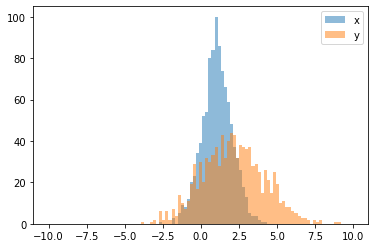

In [16]:
bins = np.linspace(-10, 10, 100)

plt.hist(control_values, bins, alpha=0.5, label='x')
plt.hist(test_values, bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

In [17]:
control_data = [get_row(str(get_entity_id(idx, NUM_ENTITIES)), "control", value)\
                for idx, value in enumerate(control_values)]

test_data = [get_row(str(get_entity_id(idx, NUM_ENTITIES)), "treatment", value)\
             for idx, value in enumerate(test_values)]

In [18]:
df = spark.createDataFrame(data=(control_data + test_data))

In [19]:
df.show(5)

+---------+------+----------+----------+------------+-------------------+----------+---------+
|entityUid|experimentUid|isAdditive|metricName|metricSource|        metricValue| timestamp|variantId|
+---------+------+----------+----------+------------+-------------------+----------+---------+
|        0|   exp|      true|        ts|    feedback| 0.6058181437061179|1639302885|  control|
|        1|   exp|      true|        ts|    feedback|   2.85678678579561|1639302885|  control|
|        2|   exp|      true|        ts|    feedback|  1.200365617789879|1639302885|  control|
|        3|   exp|      true|        ts|    feedback| 1.4786937731429313|1639302885|  control|
|        4|   exp|      true|        ts|    feedback|-0.6635258461644913|1639302885|  control|
+---------+------+----------+----------+------------+-------------------+----------+---------+
only showing top 5 rows



In [20]:
cum = CumulativeMetricTransformer()
outlier = OutlierRemoveTransformer()
stat = AutoStatisticsTransformer()
pipeline = Pipeline(stages=[cum, outlier, stat])

In [21]:
stat_result = pipeline.fit(df).transform(df)

In [22]:
stat_result.select(
  "metricName",
  "experimentUid",
  "statisticsData.srm",
  "statisticsData.testType",
  "statisticsData.statResult.pValue",
  "statisticsData.statResult.requiredSampleSizeByVariant",
  "statisticsData.statResult.percentageLeft",
  "statisticsData.statResult.percentageRight"
).toPandas().head()

,metricName,experimentUid,srm,testType,pValue,requiredSampleSizeByVariant,percentageLeft,percentageRight
0,ts,exp,False,WELCH,5.426406e-37,5,83.369017,112.488061
